In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

## Ссылки:
* [Chris Olah's blog (LSTM/GRU)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [PyTorch tutorial - RNN for name classification](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
* [MNIST classification with RNN tutorial](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
* [Good tutorials about Torch sentiment](https://github.com/bentrevett/pytorch-sentiment-analysis)

## Vanilla RNN

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width="600">

$$\Large h_{i+1} = tanh(W_x \cdot X_{i+1} + W_y \cdot h_{i})$$

Рекурретные нейросети нужны для работы с **последовательными данными** произвольной длины. Они представляют собой абстрактные ячейки, у которых есть какая-то **память** (hidden state), которая обновляется после обработки очередной порции данных.

Если в самом простом виде, то в рекуррентных сетках для одного входного вектора $x_{(t)}$ и одного слоя рекуррентной сети справедливо такое соотношение:

$$y_{(t)} = \phi (x_{(t)}^T \cdot w_x + y_{(t-1)}^T \cdot w_y + b)$$

где 
* $x(t)$ — входной вектор на текущем шаге;
* $y(t)$ — выходной вектор на текущем шаге;
* $w_x$ — вектор весов нейронов для входа;
* $w_y$ — вектор весов нейронов для выхода;
* $y(t-1)$ — выходной вектор с прошлого шага (для первого шага этот вектор нулевой);
* $b$ — bias;
* $\phi$ — какая-то функция активации (например, ReLU).

Эту ячейку применяют по очереди ко всей последовательности, пробрасывая hidden state с предыдущего состояния. С точки зрения построения вычислительного графа это выглядит так:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="600">

То есть если зафиксировать длину последовательности, то мы получим обычный фиксированный ациклический граф вычислений, в котором просто пошерены параметры всех ячеек.

### Упрощение формулы

Снова немножко математики чтобы привести формулу выше к более удобному виду.

Представим, что на вход подается не один вектор $x_{(t)}$, а целый мини-батч размера $m$ таких векторов $X_{(t)}$, соответственно все дальнейшие размышления мы уже производим в матричном виде:

$$ Y_{(t)} = \phi(X_{(t)}^T \cdot W_x + Y_{(t-1)}^T \cdot W_y + b) = \phi([X_{(t)} Y_{(t-1)}] \cdot W + b) $$
где
$$ W = [W_x W_y]^T $$

*Операция в квадратных скобках — конкатенация матриц

По размерностям:
* $Y_{(t)}$ — матрица [$m$ x n_neurons]
* $X_{(t)}$ — матрица [$m$ x n_features]
* $b$ — вектор длины n_neurons
* $W_x$ — веса между входами и нейронами размерностью [n_features x n_neurons]
* $W_y$ — веса связей с прошлым выходом размерностью [n_neurons x n_neurons]

# RNN from scratch

**Disclaimer:** не используйте самописные RNN-ки в реальной жизни.

Давайте реализуем торчовый модуль, который это реализует.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        # <создать Wx, Wy?>
        self.Wx = torch.randn(input_size, hidden_size)
        self.Wy = torch.randn(hidden_size, hidden_size)
        self.b = torch.randn((1, hidden_size))
        self.activation = nn.ReLU()

    def forward(self, input_data, hidden):
        # <использовать Wx, Wy для полученния нового hidden>
        hidden = self.activation(input_data @ self.Wx + hidden @ self.Wy + self.b)
        return hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [ ]:
input_feature_size = 6
hidden_size=5
batch_size=1

In [ ]:
rnn = RNN(input_size=input_feature_size, hidden_size=hidden_size)
initial_hidden = rnn.init_hidden(batch_size)

In [ ]:
input_example = torch.rand([batch_size, input_feature_size])
new_hidden = rnn(input_example, initial_hidden)

In [ ]:
print(new_hidden.shape)

torch.Size([1, 5])


In [ ]:
print("initial_hidden: ", initial_hidden.numpy())
print("new_hidden: ", new_hidden.detach().numpy())

initial_hidden:  [[0. 0. 0. 0. 0.]]
new_hidden:  [[0. 0. 0. 0. 0.]]


In [ ]:
new_hidden = rnn(input_example, new_hidden)
print("new_hidden: ", new_hidden.detach().numpy())

new_hidden:  [[0. 0. 0. 0. 0.]]


**Задание**. Модифицируйте код так, чтобы на вход можно было подавать батчи размером больше 1.

In [ ]:
input_feature_size = 6
hidden_size=5
batch_size=10

In [ ]:
rnn = RNN(input_size=input_feature_size, hidden_size=hidden_size)
initial_hidden = rnn.init_hidden(batch_size)

In [ ]:
input_example = torch.rand([batch_size, input_feature_size])
new_hidden = rnn(input_example, initial_hidden)

In [ ]:
print(new_hidden.shape)

torch.Size([10, 5])


In [ ]:
print("initial_hidden: ", initial_hidden.numpy().shape)
print("new_hidden: ", new_hidden.detach().numpy().shape)

initial_hidden:  (10, 5)
new_hidden:  (10, 5)


In [ ]:
new_hidden = rnn(input_example, new_hidden)
print("new_hidden: ", new_hidden.detach().numpy().shape)

new_hidden:  (10, 5)


# Классификация картинок с RNN

Представьте, что у вас есть какая-то длинная картинка, в которой свёртки точно не зайдут. Например, снимки со спутника, спектрограмма или длиннокот.

Можно обработать их построчно с помощью рекуррентных сетей — просто подавать в качестве входа все пиксели очередной строки.

<img src="https://cdn-images-1.medium.com/max/2000/1*wFYZpxTTiXVqncOLQd_CIQ.jpeg" width="800">

In [ ]:
!mkdir data

Загружаем данные

In [ ]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# переводим все в тензоры
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
!ls -lh data/

total 4.0K
drwxr-xr-x 3 root root 4.0K Apr 22 08:27 MNIST


Populating the interactive namespace from numpy and matplotlib


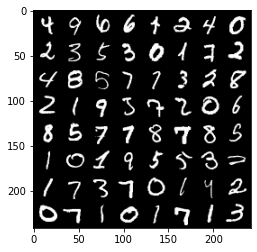

In [ ]:
%pylab inline
import numpy as np

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Как выглядит классификация с RNN в общем виде 

<img src="https://cdn-images-1.medium.com/max/1600/1*vhAfRLlaeOXZ-bruv7Ostg.png" width="400">

In [ ]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super().__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [ ]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[-0.0637, -0.0241, -0.1091,  0.0281,  0.0269,  0.0043, -0.1012, -0.0113,
         -0.0187, -0.0216],
        [-0.0709, -0.0494, -0.1475,  0.0241,  0.0403,  0.0054, -0.1509, -0.0049,
         -0.0249, -0.0186],
        [-0.0762, -0.0477, -0.1415,  0.0435,  0.0326, -0.0129, -0.1292, -0.0034,
         -0.0483, -0.0227],
        [-0.0369, -0.0235, -0.1104,  0.0212,  0.0313,  0.0041, -0.1142, -0.0106,
         -0.0418, -0.0172],
        [-0.0720, -0.0502, -0.1478,  0.0524,  0.0257, -0.0158, -0.1264, -0.0070,
         -0.0491, -0.0250],
        [-0.0739, -0.0495, -0.1525,  0.0350,  0.0327, -0.0005, -0.1464, -0.0083,
         -0.0319, -0.0195],
        [-0.0801, -0.0407, -0.1456,  0.0391,  0.0258,  0.0002, -0.1424, -0.0005,
         -0.0415, -0.0312],
        [-0.0695, -0.0512, -0.1447,  0.0257,  0.0282, -0.0032, -0.1464, -0.0103,
         -0.0213, -0.0162],
        [-0.0930, -0.0500, -0.0972,  0.0284,  0.0327, -0.0032, -0.1533, -0.0051,
         -0.0070, -0.0020],
        [-0.0759, -

## Обучаем

In [ ]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(N_EPHOCS):
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.9190 | Train Accuracy: 68.14
Epoch:  1 | Loss: 0.4026 | Train Accuracy: 87.73
Epoch:  2 | Loss: 0.2582 | Train Accuracy: 92.51
Epoch:  3 | Loss: 0.2115 | Train Accuracy: 93.93
Epoch:  4 | Loss: 0.1753 | Train Accuracy: 95.02
Epoch:  5 | Loss: 0.1657 | Train Accuracy: 95.41
Epoch:  6 | Loss: 0.1486 | Train Accuracy: 95.81
Epoch:  7 | Loss: 0.1377 | Train Accuracy: 96.14
Epoch:  8 | Loss: 0.1269 | Train Accuracy: 96.42
Epoch:  9 | Loss: 0.1262 | Train Accuracy: 96.48


### Смотрим что на тесте

In [ ]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 96.61


# Сентимент анализ

Домашка — классифицировать отзывы с IMDB на положительный / отрицательный только по тексту.

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment1.png">

Суть такая же, только нужно предобработать тексты — каждому слову сопоставить обучаемый вектор (embedding), который пойдёт дальше в RNN.

In [ ]:
# это уберет боль работы с текстами
!pip install torchtext
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 5.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


**Примечание.** Torchtext уже не очень живой проект, а в spacy нет русского.


In [ ]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

In [ ]:
from torchtext.legacy import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL, root="./data")

downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:06<00:00, 13.4MB/s]


In [ ]:
ls -lh data/imdb/aclImdb/

total 1.7M
-rw-r--r-- 1 7297 1000 882K Jun 11  2011 imdbEr.txt
-rw-r--r-- 1 7297 1000 827K Apr 12  2011 imdb.vocab
-rw-r--r-- 1 7297 1000 4.0K Jun 26  2011 README
drwxr-xr-x 4 7297 1000 4.0K Apr 12  2011 test/
drwxr-xr-x 5 7297 1000 4.0K Jun 26  2011 train/


In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [ ]:
print(vars(train_data.examples[0]))

{'text': ['"', 'Foxes', '"', 'is', 'a', 'great', 'film', '.', 'The', 'four', 'young', 'actresses', 'Jodie', 'Foster', ',', 'Cherie', 'Currie', ',', 'Marilyn', 'Kagan', 'and', 'Kandice', 'Stroh', 'are', 'wonderful', '.', 'The', 'song', '"', 'On', 'the', 'radio', '"', 'by', 'Donna', 'Summer', 'is', 'lovely', '.', 'A', 'great', 'film', '.', '*', '*', '*', '*', '*'], 'label': 'pos'}


In [ ]:
# Сделаем еще eval
import random

train_data, valid_data = train_data.split(random_state=random.seed(SEED))

In [ ]:
# Сделаем словарь
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [ ]:
vars(LABEL.vocab)

{'freqs': Counter({'neg': 8810, 'pos': 8690}),
 'itos': ['neg', 'pos'],
 'stoi': defaultdict(None, {'neg': 0, 'pos': 1}),
 'unk_index': None,
 'vectors': None}

Почему 25002, а не 25000?
Потому что $<unk>$ и $<pad>$

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment6.png" width="160">

In [ ]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 202321), (',', 193118), ('.', 166458), ('and', 109888), ('a', 109470), ('of', 100511), ('to', 94236), ('is', 76622), ('in', 61342), ('I', 54566), ('it', 53608), ('that', 49336), ('"', 44142), ("'s", 43442), ('this', 42433), ('-', 36831), ('/><br', 35783), ('was', 34701), ('as', 30488), ('with', 30092)]


* stoi (string to int)
* itos (int to string)

In [ ]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# собираем батчи так, чтобы в каждом батче были примеры наиболее похожей длины
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device)

## Делаем модель

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment7.png" width="450">

* В эмбеддер (emb = [torch.nn.Embedding(num_embeddings, embedding_dim)](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding)) запихиваем тензор размерностью **[sentence length, batch size]**
* Эмбеддер возвращает тензор размерностью **[sentence length, batch size, embedding dim]**
* RNN (torch.nn.RNN(embedding_dim, hidden_dim)) возвращает 2 тензора, *output* размера [sentence length, batch size, hidden dim] и *hidden* размера [1, batch size, hidden dim]

Попробую несколько архитектур:
1. LSTM

In [ ]:
class RNNLSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, bidirectional = True)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_dim, 1),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.rnn(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        output = self.fc(hidden)
        return self.sigmoid(output)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
model = RNNLSTM(len(TEXT.vocab), 64, 20).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
num_epochs = 50

In [ ]:
from tqdm.auto import tqdm 

for epoch in tqdm(range(num_epochs)):
    model.train()
    for batch in train_iterator:
        optimizer.zero_grad()
        text = batch.text
        label = batch.label
        output = model(text)
        loss = criterion(output.reshape(-1), label)
        loss.backward()
        optimizer.step()
    sum_acc = 0
    num_batches = 0
    model.eval()
    for batch in valid_iterator:
        text = batch.text
        label = batch.label
        output = model(text) > 0.5
        sum_acc += torch.sum(output.reshape(-1) == label) / len(label)
        num_batches += 1
    print(f"Mean accuracy per epoch {epoch + 1} : {sum_acc / num_batches}")

  0%|          | 0/50 [00:00<?, ?it/s]

Mean accuracy per epoch 1 : 0.5636917352676392
Mean accuracy per epoch 2 : 0.6465395092964172
Mean accuracy per epoch 3 : 0.7017567157745361
Mean accuracy per epoch 4 : 0.6590307354927063
Mean accuracy per epoch 5 : 0.7327859997749329
Mean accuracy per epoch 6 : 0.7480137944221497
Mean accuracy per epoch 7 : 0.7563117742538452
Mean accuracy per epoch 8 : 0.7522510886192322
Mean accuracy per epoch 9 : 0.7733050584793091
Mean accuracy per epoch 10 : 0.7590042352676392
Mean accuracy per epoch 11 : 0.7189265489578247
Mean accuracy per epoch 12 : 0.7756444215774536
Mean accuracy per epoch 13 : 0.7870321273803711
Mean accuracy per epoch 14 : 0.7845162153244019
Mean accuracy per epoch 15 : 0.7865907549858093
Mean accuracy per epoch 16 : 0.7801907062530518
Mean accuracy per epoch 17 : 0.766287088394165
Mean accuracy per epoch 18 : 0.7750265002250671
Mean accuracy per epoch 19 : 0.7825741767883301
Mean accuracy per epoch 20 : 0.776792049407959
Mean accuracy per epoch 21 : 0.7803230881690979
Mea

Значение accuracy на тесте:

In [ ]:
def test_accurac(model):
    sum_acc = 0
    num_batches = 0
    model.eval()
    for batch in test_iterator:
        text = batch.text
        label = batch.label
        output = model(text) > 0.5
        sum_acc += torch.sum(output.reshape(-1) == label) / len(label)
        num_batches += 1
    return sum_acc / num_batches

In [ ]:
test_accurac(model)

tensor(0.7598, device='cuda:0')

2. GRU

In [ ]:
class RNNGRU(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, bidirectional = True)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_dim, 1),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        #print(output.shape, hidden.shape)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        output = self.fc(hidden)
        return self.sigmoid(output)

In [ ]:
model = RNNGRU(len(TEXT.vocab), 64, 20).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
num_epochs = 20

In [ ]:
from tqdm.auto import tqdm 

for epoch in tqdm(range(num_epochs)):
    model.train()
    for batch in train_iterator:
        optimizer.zero_grad()
        text = batch.text
        label = batch.label
        output = model(text)
        loss = criterion(output.reshape(-1), label)
        loss.backward()
        optimizer.step()
    sum_acc = 0
    num_batches = 0
    model.eval()
    for batch in valid_iterator:
        text = batch.text
        label = batch.label
        output = model(text) > 0.5
        sum_acc += torch.sum(output.reshape(-1) == label) / len(label)
        num_batches += 1
    print(f"Mean accuracy per epoch {epoch + 1} : {sum_acc / num_batches}")

  0%|          | 0/20 [00:00<?, ?it/s]

Mean accuracy per epoch 1 : 0.5437852740287781
Mean accuracy per epoch 2 : 0.7043167352676392
Mean accuracy per epoch 3 : 0.7456744313240051
Mean accuracy per epoch 4 : 0.7811617255210876
Mean accuracy per epoch 5 : 0.7915784120559692
Mean accuracy per epoch 6 : 0.8005384802818298
Mean accuracy per epoch 7 : 0.8096310496330261
Mean accuracy per epoch 8 : 0.8096750974655151
Mean accuracy per epoch 9 : 0.8024805784225464
Mean accuracy per epoch 10 : 0.8218573331832886
Mean accuracy per epoch 11 : 0.8215042352676392
Mean accuracy per epoch 12 : 0.8218132257461548
Mean accuracy per epoch 13 : 0.8209304213523865
Mean accuracy per epoch 14 : 0.8161634802818298
Mean accuracy per epoch 15 : 0.8211952447891235
Mean accuracy per epoch 16 : 0.8175317645072937
Mean accuracy per epoch 17 : 0.817355215549469
Mean accuracy per epoch 18 : 0.8058792352676392
Mean accuracy per epoch 19 : 0.8024364709854126
Mean accuracy per epoch 20 : 0.8105579614639282


In [ ]:
test_accurac(model)

tensor(0.7850, device='cuda:0')

3. RNN

In [ ]:
class RNNDefault(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim,bidirectional = True)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_dim, 1),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        output = self.fc(hidden)
        return self.sigmoid(output)

In [ ]:
model = RNNDefault(len(TEXT.vocab), 64, 20).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
num_epochs = 20

In [206]:
from tqdm.auto import tqdm 

for epoch in tqdm(range(num_epochs)):
    model.train()
    for batch in train_iterator:
        optimizer.zero_grad()
        text = batch.text
        label = batch.label
        output = model(text)
        loss = criterion(output.reshape(-1), label)
        loss.backward()
        optimizer.step()
    sum_acc = 0
    num_batches = 0
    model.eval()
    for batch in valid_iterator:

        text = batch.text
        label = batch.label
        output = model(text) > 0.5
        sum_acc += torch.sum(output.reshape(-1) == label) / len(label)
        num_batches += 1
    print(f"Mean accuracy per epoch {epoch + 1} : {sum_acc / num_batches}")

  0%|          | 0/20 [00:00<?, ?it/s]

Mean accuracy per epoch 1 : 0.5449329614639282
Mean accuracy per epoch 2 : 0.5718132257461548
Mean accuracy per epoch 3 : 0.6242496967315674
Mean accuracy per epoch 4 : 0.5797140002250671
Mean accuracy per epoch 5 : 0.6396539211273193
Mean accuracy per epoch 6 : 0.6714335680007935
Mean accuracy per epoch 7 : 0.6905455589294434
Mean accuracy per epoch 8 : 0.6744791269302368
Mean accuracy per epoch 9 : 0.6922227740287781
Mean accuracy per epoch 10 : 0.6950918436050415
Mean accuracy per epoch 11 : 0.6986228823661804
Mean accuracy per epoch 12 : 0.7067002058029175
Mean accuracy per epoch 13 : 0.7133651375770569
Mean accuracy per epoch 14 : 0.7127471566200256
Mean accuracy per epoch 15 : 0.7025070786476135
Mean accuracy per epoch 16 : 0.7176465392112732
Mean accuracy per epoch 17 : 0.7154837846755981
Mean accuracy per epoch 18 : 0.7082892060279846
Mean accuracy per epoch 19 : 0.7199859023094177
Mean accuracy per epoch 20 : 0.6876765489578247


In [207]:
test_accurac(model)

tensor(0.6583, device='cuda:0')

Вывод : GRU топ